# Demo of SF error analysis
**Semi-empirical approach to computing second-order statistics of gapped series**

Structure functions = statistical moments of increments:
$$D_p(\tau)=\langle | x(t+\tau)-x(t))^p | \rangle$$

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import ts_dashboard_utils as ts
import src.utils as utils  # copied directly from Reynolds project, normalize() added
import src.sf_funcs as sf
import pickle

plt.rcParams.update({"font.size": 12})

# Set seed for reproducibility
np.random.seed(42)

## Load in the data
A magnetic field time series from PSP, already processed into Pandas DataFrame format

In [2]:
df_raw_full = pd.read_pickle("data/processed/psp/psp_fld_l2_mag_rtn_201811.pkl")
df_raw = df_raw_full["B_R"]
df_raw.head()

Time
2018-11-02 00:01:09.195182976   -11.061315
2018-11-02 00:01:09.208836480   -10.854164
2018-11-02 00:01:09.222489856   -11.197883
2018-11-02 00:01:09.236143104   -11.008248
2018-11-02 00:01:09.249796352   -11.188342
Name: B_R, dtype: float64

Optionally, check the data for missing data and its frequency, get summary stats

In [3]:
### 0PTIONAL CODE ###

if df_raw.isnull().sum() == 0:
    print("No missing data")
else:
    print(f"{df_raw.isnull().sum()} missing points")
print("Length of interval: " + str(df_raw.notnull().sum()))
print("Duration of interval: " + str(df_raw.index[-1] - df_raw.index[0]))
x = df_raw.values

# Frequency of measurements
print("Duration between some adjacent data points:")
print(df_raw.index[2] - df_raw.index[1])
print(df_raw.index[3] - df_raw.index[2])
print(df_raw.index[4] - df_raw.index[3])

a = df_raw.index[2] - df_raw.index[1]
x_freq = 1 / (a.microseconds / 1e6)
print("\nFrequency is {0:.2f} Hz (2dp)".format(x_freq))

print("Mean = {}".format(np.mean(x)))
print("Standard deviation = {}".format(np.std(x)))

### 0PTIONAL CODE END ###

510 missing points
Length of interval: 7522952
Duration of interval: 0 days 17:59:59.987519872
Duration between some adjacent data points:
0 days 00:00:00.013653376
0 days 00:00:00.013653248
0 days 00:00:00.013653248

Frequency is 73.24 Hz (2dp)
Mean = nan
Standard deviation = nan


## Standardise each interval 
to contain 8 correlation times `tc`. Start with *approximately* 15 correlation times across 75,000 points, then calculate correlation time and use this value to down-sample to 8 correlation times across 10,000 points.

In [4]:
tc_approx = 500  # s
tc_approx_n = 15
cadence_approx = 0.1  # s

tc_n = 8  # Number of correlation times we want...
interval_length = 4000  # ...across this many points
good_inputs_list = []

df = df_raw.resample(str(cadence_approx) + "S").mean()
interval_length_approx = int(tc_approx * tc_approx_n / cadence_approx)

In [5]:
# Original freq is 0.007s. Resampling to less rapid but still sufficiently high cadence, then splitting into chunks with ~15 correlation times

tc_approx = 500  # s
tc_approx_n = 15
cadence_approx = 0.1  # s

tc_n = 8  # Number of correlation times we want...
interval_length = 4000  # ...across this many points
good_inputs_list = []

df = df_raw.resample(str(cadence_approx) + "S").mean()
interval_length_approx = int(tc_approx * tc_approx_n / cadence_approx)

# We have approximately 15 correlation times in 10,000 points. Let's now be more precise, and calculate the correlation time from each chunk

# Split df into subsets
interval_list_approx = [
    df[i : i + interval_length_approx]
    for i in range(0, len(df) - interval_length_approx + 1, int(interval_length_approx))
]

del df  # free up memory

tc_list = []

for interval_approx in interval_list_approx:
    time_lags_lr, r_vec_lr = utils.compute_nd_acf(
        [interval_approx],
        nlags=10000,
        plot=False,
    )

    tc = utils.compute_outer_scale_exp_trick(time_lags_lr, r_vec_lr, plot=False)

    if tc == -1:
        tc = 500
        new_cadence = tc_n * tc / interval_length
        print(
            f"tce not found for this chunk, setting to 500s (default) -> cadence = {new_cadence}s"
        )

    else:
        new_cadence = tc_n * tc / interval_length
        print(
            f"tce calculated to be {np.round(tc,2)}s -> cadence = {np.round(new_cadence,2)}s (for {tc_n}tce across {interval_length} points)"
        )

    tc_list.append(tc)

    interval_approx_resampled = interval_approx.resample(
        str(new_cadence) + "S"
    ).mean()  # Resample to higher frequency

    for i in range(
        0, len(interval_approx_resampled) - interval_length + 1, interval_length
    ):
        interval = interval_approx_resampled.iloc[i : i + interval_length]
        int_norm = utils.normalize(interval)
        good_inputs_list.append(int_norm)

print(
    "\nNumber of standardised intervals: "
    + str(len(good_inputs_list))
    + "\n(may be more than one per original chunk for small cadences)"
)

tce calculated to be 472.44s -> cadence = 0.94s (for 8tce across 4000 points)
tce calculated to be 519.81s -> cadence = 1.04s (for 8tce across 4000 points)
tce calculated to be 724.28s -> cadence = 1.45s (for 8tce across 4000 points)
tce calculated to be 612.58s -> cadence = 1.23s (for 8tce across 4000 points)
tce not found for this chunk, setting to 500s (default) -> cadence = 1.0s
tce calculated to be 181.96s -> cadence = 0.36s (for 8tce across 4000 points)
tce calculated to be 860.62s -> cadence = 1.72s (for 8tce across 4000 points)
tce not found for this chunk, setting to 500s (default) -> cadence = 1.0s

Number of standardised intervals: 12
(may be more than one per original chunk for small cadences)


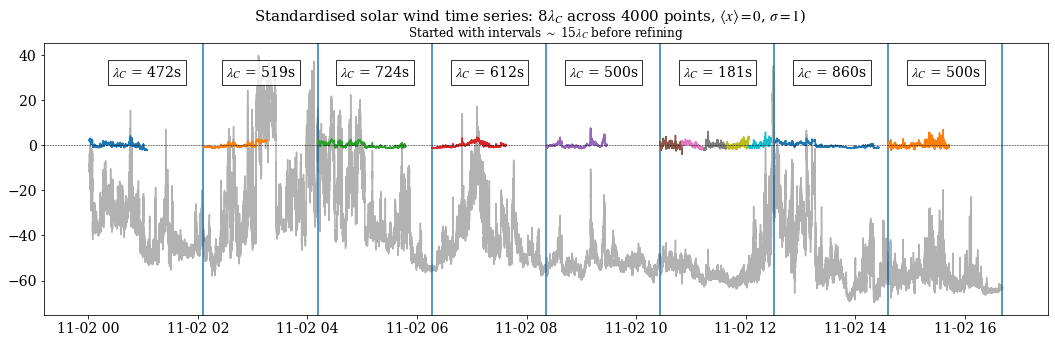

In [6]:
plt.rcParams.update({"font.size": 14})

fig, ax = plt.subplots(figsize=(18, 5))
[plt.plot(interval, alpha=0.3, c="black") for interval in interval_list_approx]
[plt.axvline(interval.index[-1]) for interval in interval_list_approx]
[plt.plot(interval) for interval in good_inputs_list]
plt.axhline(0, c="black", linewidth=0.5, linestyle="--")
for index, tc in enumerate(tc_list):
    plt.text(
        x=interval_list_approx[index].index[0] + pd.Timedelta(seconds=1500),
        y=30,
        s=f"$\lambda_C$ = {int(tc)}s",
        bbox=dict(facecolor="white", alpha=0.8),
    )
plt.suptitle(
    f"Standardised solar wind time series: {tc_n}$\lambda_C$ across {interval_length} points, $\langle x \\rangle=0$, $\sigma=1$)",
    fontsize=15,
)
# Add subtitle
plt.title("Started with intervals $\sim$ 15$\lambda_C$ before refining", fontsize=12)

plt.savefig("plots/int_standardised_demo.png")
plt.rcParams.update({"font.size": 12})

Mostly, we can just fit one time series of 8tc into each original one of about 2 hours. (8tc is approx 80min).

In [7]:
for interval in good_inputs_list:
    print(len(interval))

4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000


## Get gapped statistics
Remove data from each input multiple times and compute SF, naive and interpolated: **currently handled by `get_gapped_sf.py` script**

---

## Analyse and plot results

In [1]:
# Read in pickle file data/processed/list_of_list_of_dfs.pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import ts_dashboard_utils as ts
import utils as utils  # copied directly from Reynolds project, normalize() added
import sf_funcs as sf
import pickle
import importlib

importlib.reload(sf)

with open("data/processed/sfs_psp_core_0.pkl", "rb") as f:
    list_of_list_of_dfs = pickle.load(f)

# Unpack the list of list of dfs
(
    good_inputs_list,
    good_outputs_list,
    all_bad_inputs_list,
    all_bad_outputs_list,
    all_interp_inputs_list,
    all_interp_outputs_list,
) = list_of_list_of_dfs

In [2]:
print(
    f"{len(all_interp_outputs_list[0])} versions of {len(all_interp_outputs_list)} outputs"
)

2 versions of 98 outputs


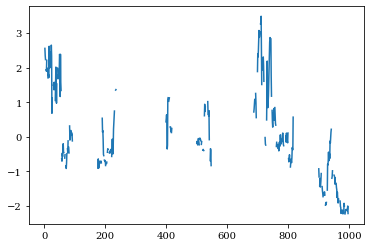

In [4]:
plt.plot(all_bad_inputs_list[0][1])

In [5]:
# Perform random train-test split
from sklearn.model_selection import train_test_split

(
    good_inputs_train,
    good_inputs_test,
    good_outputs_train,
    good_outputs_test,
    bad_inputs_train,
    bad_inputs_test,
    bad_outputs_train,
    bad_outputs_test,
    interp_inputs_train,
    interp_inputs_test,
    interp_outputs_train,
    interp_outputs_test,
) = train_test_split(
    good_inputs_list,
    good_outputs_list,
    all_bad_inputs_list,
    all_bad_outputs_list,
    all_interp_inputs_list,
    all_interp_outputs_list,
    test_size=0.2,
    random_state=42,
)
print(
    f"Number of training interval: {len(good_inputs_train)} x {len(bad_inputs_train[0])} = {len(good_inputs_train)*len(bad_inputs_train[0])}"
)
print(
    f"Number of test intervals: {len(good_inputs_test)} x {len(bad_inputs_test[0])} = {len(good_inputs_test)*len(bad_inputs_test[0])}"
)

Number of training interval: 78 x 2 = 156
Number of test intervals: 20 x 2 = 40


### Naive

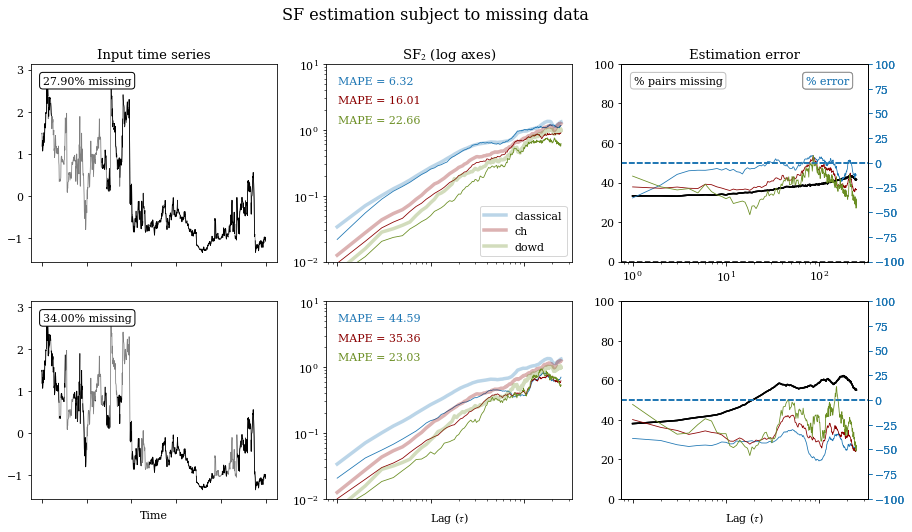

In [19]:
# Check results, for a given clean input
importlib.reload(sf)

input_ind = 8
n_versions_to_plot = 2

sf.plot_sample(
    good_inputs_test,
    good_outputs_test,
    bad_inputs_test,
    bad_outputs_test,
    input_ind,
    n_versions_to_plot,
    False,
)
# plt.savefig("plots_local/psp_missing_effect.png")

### Interpolated
NB: Error region for these results are taken from the SE for the naive calculations, reflecting the increased uncertainty of fewer *true* observations

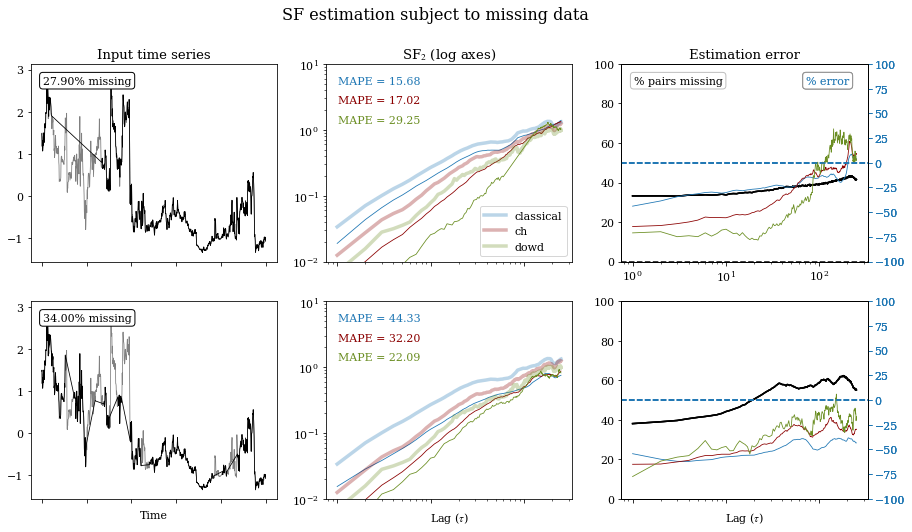

In [57]:
importlib.reload(sf)
sf.plot_sample(
    good_inputs_test,
    good_outputs_test,
    interp_inputs_test,
    interp_outputs_test,
    input_ind,
    n_versions_to_plot,
    False,
    # "sosf",
)
# plt.savefig("plots/psp_missing_effect_lint.png")

## Do holistic analysis of errors

In [9]:
# Concatenate the list of lists of dataframes to a single dataframe for error analysis
def concat_dfs(lst_of_list_of_dfs):
    merged_df = pd.concat(
        [pd.concat(lst, keys=range(len(lst))) for lst in lst_of_list_of_dfs],
        keys=range(len(lst_of_list_of_dfs)),
    )
    # Renaming MultiIndex levels
    merged_df.index.names = ["Original interval", "Interval version", "Lag"]
    return merged_df


bad_outputs_train_df = concat_dfs(bad_outputs_train)
interp_outputs_train_df = concat_dfs(interp_outputs_train)
bad_outputs_test_df = concat_dfs(bad_outputs_test)
interp_outputs_test_df = concat_dfs(interp_outputs_test)

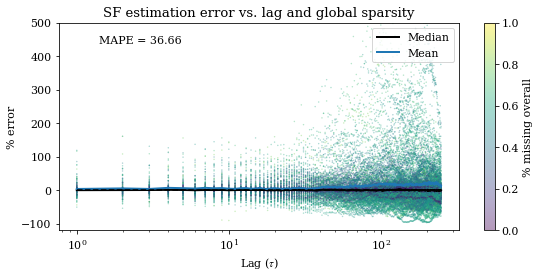

In [10]:
# View trends as fn of OVERALL missing amount
sf.plot_error_trend_line(bad_outputs_train_df, estimator="dowd")
# plt.savefig("plots/psp_missing_effect_holistic.png")

In [11]:
def plot_average_errors(df):
    stats = df.groupby("Lag")["classical_error_percent"].describe()
    plt.plot(stats["mean"], lw=3, label="Mean % error")
    plt.plot(stats["50%"], lw=3, label="Median % error")
    plt.semilogx()
    plt.legend()
    plt.title("Average error as a function of lag, no handling, classical est.")


plot_average_errors(bad_outputs_train_df)
# plt.savefig("plots/psp_missing_effect_holistic_avg.png")

KeyError: 'Column not found: sosf_error_percent'

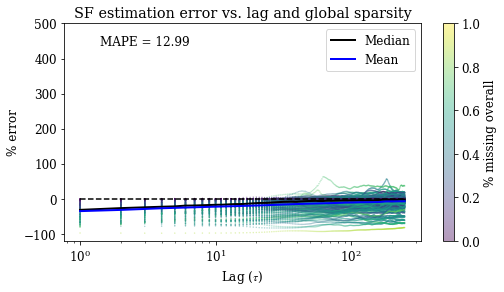

In [ ]:
sf.plot_error_trend_line(interp_outputs_train_df)
# plt.savefig("plots/psp_missing_effect_holistic_lint.png")

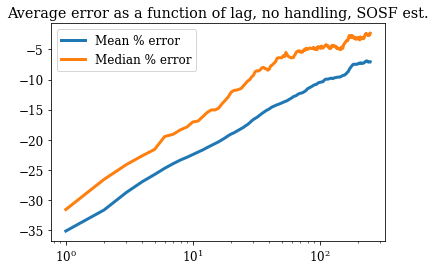

In [ ]:
plot_average_errors(interp_outputs_train_df)
# plt.savefig("plots/psp_missing_effect_holistic_lint_avg.png")

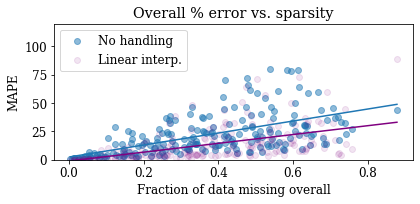

In [ ]:
sf.plot_error_trend_scatter(bad_outputs_train_df, interp_outputs_train_df)
# plt.savefig("plots/psp_missing_effect_holistic_scatter.png")

In [26]:
# Investigating weird spikes at small lag
interp_outputs_train_df.sort_values("classical_error_percent", ascending=False).head(5)

n  0.5_mean   0.5_std  \
Original interval Interval version Lag                              
6                 0                232.0  768  0.971237  0.498302   
                                   181.0  819  0.954307  0.467429   
                                   233.0  767  0.971539  0.499356   
                                   231.0  769  0.971516  0.497031   
                                   235.0  765  0.974410  0.495407   

                                          0.5_std_err    lag  classical  \
Original interval Interval version Lag                                    
6                 0                232.0     0.017981  232.0   2.568584   
                                   181.0     0.016333  181.0   2.176880   
                                   233.0     0.018031  233.0   2.577967   
                                   231.0     0.017923  231.0   2.566383   
                                   235.0     0.017911  235.0   2.583315   

                                              mapd  classical_se        ch  \
Original interval Interval version Lag                                       
6                 0                232.0  0.714823      0.263797  1.944344   
                                   181.0  0.705567      0.201974  1.812440   
                                   233.0  0.707979      0.275943  1.946761   
                                   231.0  0.709908      0.263893  1.946583   
                                   235.0  0.716861      0.269512  1.969872   

                                              dowd  missing_prop  \
Original interval Interval version Lag                             
6                 0                232.0  1.123118      0.873698   
                                   181.0  1.094218      0.857143   
                                   233.0  1.101714      0.870926   
                                   231.0  1.107724      0.876463   
                                   235.0  1.129528      0.870588   

                                          classical_error  \
Original interval Interval version Lag                      
6                 0                232.0         1.466926   
                                   181.0         1.242806   
                                   233.0         1.470102   
                                   231.0         1.461907   
                                   235.0         1.469195   

                                          classical_error_percent  ch_error  \
Original interval Interval version Lag                                        
6                 0                232.0               133.156173  1.134186   
                                   181.0               133.052195  1.112552   
                                   233.0               132.696891  1.143479   
                                   231.0               132.361945  1.139929   
                                   235.0               131.870461  1.138115   

                                          ch_error_percent  dowd_error  \
Original interval Interval version Lag                                   
6                 0                232.0        139.995553    0.446932   
                                   181.0        158.961565    0.495233   
                                   233.0        142.350920    0.397307   
                                   231.0        141.315716    0.451991   
                                   235.0        136.832465    0.422772   

                                          dowd_error_percent  \
Original interval Interval version Lag                         
6                 0                232.0           66.095973   
                                   181.0           82.678626   
                                   233.0           56.403074   
                                   231.0           68.929090   
                                   235.0           59.818688   

                                          missing_prop_overa

## Create empirical correction factor

Here we work with the interpolated output errors, as they are more consistent that the no-handling errors (as evident in the error vs. lag and global sparsity plot), and with the *local* sparsity, as this gives us more information than the global sparsity.

In [27]:
missing_measure = "missing_prop"
n_bins = 15

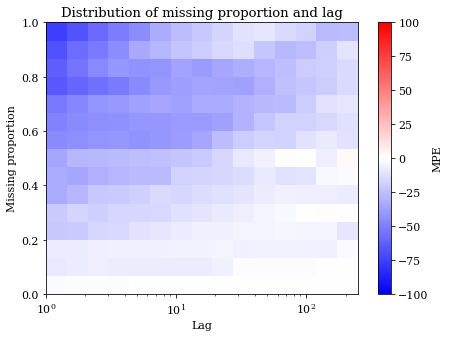

In [41]:
heatmap_bin_vals, heatmap_bin_edges, lookup_table = sf.create_heatmap_lookup(
    interp_outputs_train_df, missing_measure, n_bins, log=True
)

# If wanting linear bins, can then simply use the following:

# axs = sf.plot_heatmap(
#     heatmap_bin_vals,
#     heatmap_bin_edges,
#     "Missing proportion",
#     False,
# )

fig, ax = plt.subplots(figsize=(7, 5))
plt.pcolormesh(
    heatmap_bin_edges_log[0],
    heatmap_bin_edges_log[1],
    heatmap_bin_vals_log.T,
    cmap="bwr",
)
plt.colorbar(label="MPE")
plt.clim(-100, 100)
plt.xlabel("Lag")
plt.ylabel("Missing proportion")
plt.title("Distribution of missing proportion and lag")
ax.set_facecolor("black")
ax.set_xscale("log")
# plt.savefig(f"plots/psp_correction_heatmap_{n_bins}_bins.png")

Check out sample size in each bin (above just shows where there is no data with black bins).
Below 2D histogram is not working for log bins, for some reason

Text(0.5, 1.0, 'Distribution of missing proportion and lag')

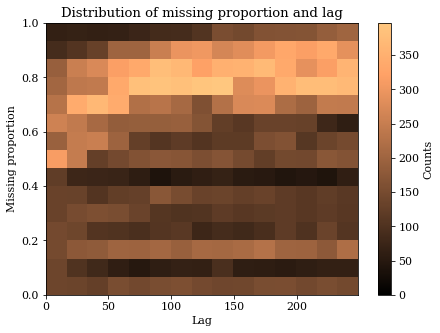

In [42]:
fig, ax = plt.subplots(figsize=(7, 5))
hb = ax.hist2d(
    interp_outputs_train_df["lag"],
    interp_outputs_train_df[missing_measure],
    bins=n_bins,
    cmap="copper",
    range=[[0, interp_outputs_train_df.lag.max()], [0, 1]],
)
plt.colorbar(hb[3], ax=ax, label="Counts")
hb[3].set_clim(0, hb[0].max())
plt.xlabel("Lag")
plt.ylabel("Missing proportion")
plt.title("Distribution of missing proportion and lag")
# plt.savefig("plots/psp_heatmap_sample_size.png")

In [43]:
# Compute heatmap of average error as fn of lag and missing prop at that lag
heatmap_bin_vals_3d, heatmap_bin_edges_3d, lookup_table_3d = (
    sf.create_heatmap_lookup_3D(interp_outputs_train_df, missing_measure, n_bins, True)
)

## Apply empirical correction factor to bad SFs

*Regardless of whether I save to it again, `interp_outputs_test_df` is edited within the function each time, which is fine by me.*

In [45]:
interp_outputs_test_df = sf.compute_scaling(
    interp_outputs_test_df, missing_measure, lookup_table
)

In [46]:
interp_outputs_test_df = sf.compute_scaling_3d(
    interp_outputs_test_df, missing_measure, lookup_table_3d
)

In [47]:
print(
    "Mean MAPE of interpolated intervals in test set = {:.2f}".format(
        interp_outputs_test_df["classical_error_percent"].abs().mean()
    )
)

# Calculate corrected test set error
error_percents_2d = []
error_percents_3d = []
times_to_gap = 2

for i, df in enumerate(good_outputs_test):
    for j in range(times_to_gap):
        # Calculate difference
        error_2d = (
            interp_outputs_test_df.loc[(i, j), "classical_corrected"] - df["classical"]
        )
        error_percent_2d = error_2d / df["classical"] * 100
        error_percents_2d.append(error_percent_2d)

        error_3d = (
            interp_outputs_test_df.loc[(i, j), "classical_corrected_3d"]
            - df["classical"]
        )
        error_percent_3d = error_3d / df["classical"] * 100
        error_percents_3d.append(error_percent_3d)

print(
    "Mean MAPE of corrected (2D) interpolated intervals test set = {:.2f}".format(
        np.mean(np.abs(error_percents_2d))
    )
)
print(
    "Mean MAPE of corrected (3D) interpolated intervals test set = {:.2f}".format(
        np.mean(np.abs(error_percents_3d))
    )
)

Mean MAPE of interpolated intervals in test set = 11.30
Mean MAPE of corrected (2D) interpolated intervals test set = 11.45
Mean MAPE of corrected (3D) interpolated intervals test set = 14.62


In [48]:
interp_outputs_test_df.loc[0, 1]["classical_error_percent"].abs().mean()

0.7777204112238583

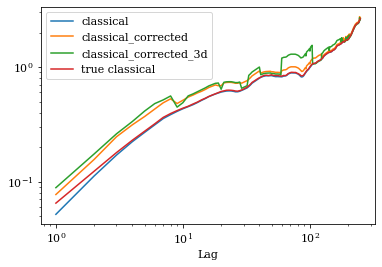

In [49]:
interp_outputs_test_df.loc[0, 1][
    ["classical", "classical_corrected", "classical_corrected_3d"]
].plot()
good_outputs_test[0]["classical"].plot(label="true classical")
plt.semilogx()
plt.semilogy()
plt.legend()
plt.show()

## Using the test set, plot the same intervals originally plotted

In [50]:
versions_ordered_sparsity = (
    interp_outputs_test_df.loc[input_ind, : n_versions_to_plot - 1, :]
    .sort_values("missing_prop_overall")
    .index.get_level_values(1)
    .unique()
    .values
)
# Extract the unique second-level indexes
for i in versions_ordered_sparsity:
    print(i)

1
0


Text(0.5, 0.98, 'Applying correction factor to interpolated SFs in test set')

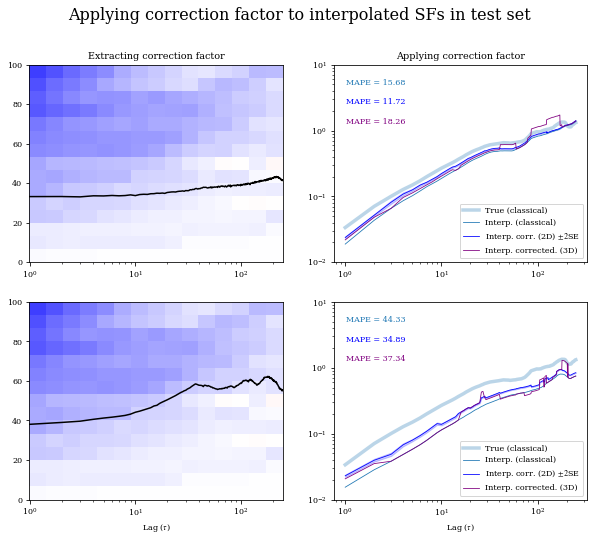

In [56]:
fig, axs = plt.subplots(n_versions_to_plot, 2, figsize=(10, 4 * n_versions_to_plot))

# Get the relevent indices in order of sparsity for better plot aesthetics
versions_ordered_sparsity = (
    interp_outputs_test_df.loc[input_ind, : n_versions_to_plot - 1, :]
    .sort_values("missing_prop_overall")
    .index.get_level_values(1)
    .unique()
    .values
)

for i, int_version in enumerate(versions_ordered_sparsity):
    mape_bad = (
        interp_outputs_test_df.loc[input_ind, int_version]["classical_error_percent"]
        .abs()
        .mean()
    )
    mape_corrected = (
        error_percents_2d[input_ind * times_to_gap + int_version].abs().mean()
    )
    mape_corrected_3d = (
        error_percents_3d[input_ind * times_to_gap + int_version].abs().mean()
    )

    axs[i, 1].annotate(
        "MAPE = {:.2f}".format(mape_bad),
        xy=(1, 1),
        xycoords="axes fraction",
        xytext=(0.05, 0.9),
        textcoords="axes fraction",
        transform=axs[i, 1].transAxes,
        c="C0",
        bbox=dict(facecolor="white", edgecolor="white", boxstyle="round"),
    )

    axs[i, 1].annotate(
        "MAPE = {:.2f}".format(mape_corrected),
        xy=(1, 1),
        xycoords="axes fraction",
        xytext=(0.05, 0.8),
        textcoords="axes fraction",
        transform=axs[i, 1].transAxes,
        c="blue",
        bbox=dict(facecolor="white", edgecolor="white", boxstyle="round"),
    )

    axs[i, 1].annotate(
        "MAPE = {:.2f}".format(mape_corrected_3d),
        xy=(1, 1),
        xycoords="axes fraction",
        xytext=(0.05, 0.7),
        textcoords="axes fraction",
        transform=axs[i, 1].transAxes,
        c="purple",
        bbox=dict(facecolor="white", edgecolor="white", boxstyle="round"),
    )

    axs[i, 1].plot(
        good_outputs_test[input_ind]["classical"],
        color="C0",
        label="True (classical)",
        lw=3.5,
        alpha=0.3,
    )
    axs[i, 1].plot(
        interp_outputs_test_df.loc[input_ind, int_version]["classical"],
        color="C0",
        lw=0.8,
        label="Interp. (classical)",
    )
    # axs[i, 1].plot(
    #     sf_corrected["classical"] * sf_corrected["scaling"], c="blue", label="Corrected Bad"
    # )
    axs[i, 1].plot(
        interp_outputs_test_df.loc[input_ind, int_version]["classical_corrected"],
        c="blue",
        lw=0.8,
        label="Interp. corr. (2D) $\pm 2$SE",
    )
    axs[i, 1].fill_between(
        interp_outputs_test_df.loc[input_ind, int_version]["lag"],
        interp_outputs_test_df.loc[input_ind, int_version]["classical_corrected_lower"],
        interp_outputs_test_df.loc[input_ind, int_version]["classical_corrected_upper"],
        color="blue",
        alpha=0.2,
    )
    #    axs[i, 1].plot(
    #        sf_corrected["classical_corrected_smoothed"],
    #        c="orange",
    #        label="Corrected Bad Smoothed",
    #    )
    axs[i, 1].plot(
        interp_outputs_test_df.loc[input_ind, int_version]["classical_corrected_3d"],
        c="purple",
        lw=0.8,
        label="Interp. corrected. (3D)",
    )
    axs[i, 1].semilogx()
    axs[i, 1].semilogy()
    axs[i, 1].set_ylim(1e-2, 1e1)
    axs[i, 1].legend(loc="lower right")

    # if log is True:
    c = axs[i, 0].pcolormesh(
        heatmap_bin_edges[0],
        heatmap_bin_edges[1] * 100,  # convert to % Missing
        heatmap_bin_vals.T,
        cmap="bwr",
    )
    # fig.colorbar(c, ax=axs[i, 0], label="MPE")
    c.set_clim(-100, 100)
    c.set_facecolor("black")
    # axs[i, 0].set_xlabel("Lag")
    axs[i, 0].plot(
        interp_outputs_test_df.loc[input_ind, int_version]["lag"],
        interp_outputs_test_df.loc[input_ind, int_version][missing_measure] * 100,
        c="black",
    )

    axs[i, 0].set_xscale("log")
    axs[i, 0].set_ylim(0, 100)
    # axs[i, 0] = sf.plot_heatmap(
    #     heatmap_bin_vals_log,
    #     heatmap_bin_edges_log,
    #     missing_measure=missing_measure,
    #     log=True,
    #     overlay_x=df_to_plot["lag"],
    #     overlay_y=df_to_plot[missing_measure],
    #     subplot=axs[i, 0],
    # )
axs[0, 1].set_title("Applying correction factor")
axs[0, 0].set_title("Extracting correction factor")
axs[n_versions_to_plot - 1, 0].set_xlabel("Lag ($\\tau$)")
axs[n_versions_to_plot - 1, 1].set_xlabel("Lag ($\\tau$)")
fig.suptitle("Applying correction factor to interpolated SFs in test set", size=16)

## Plotting the 3D heatmap

In [52]:
plt.rcParams.update({"font.size": 8})

Text(0, 0.5, 'Missing proportion')

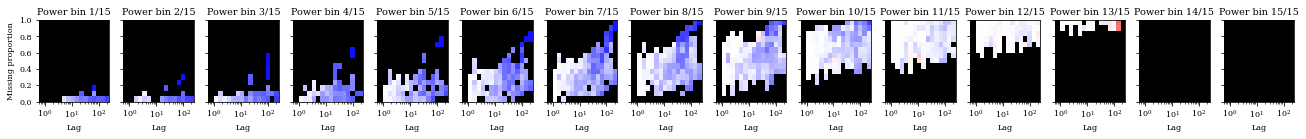

In [53]:
fig, ax = plt.subplots(1, n_bins, figsize=(1.5 * n_bins, 1.5))
# Remove spacing between subplots
plt.subplots_adjust(wspace=0.2)
for i in range(n_bins):
    c = ax[i].pcolormesh(
        heatmap_bin_edges_3d[0],
        heatmap_bin_edges_3d[1],
        heatmap_bin_vals_3d[:, :, i],
        cmap="bwr",
    )
    # plt.colorbar(label="MPE")
    c.set_clim(-100, 100)
    plt.xlabel("Lag")
    ax[i].set_xlim(6e-1, 250)
    plt.title("Distribution of missing proportion and lag")
    ax[i].set_facecolor("black")
    ax[i].semilogx()
    ax[i].set_title(
        f"Power bin {i+1}/{n_bins}".format(np.round(heatmap_bin_edges_3d[2][i], 2))
    )
    ax[i].set_xlabel("Lag")
    # Remove y-axis labels for all but the first plot
    if i > 0:
        ax[i].set_yticklabels([])
        ax[i].set_ylabel("")
ax[0].set_ylabel("Missing proportion")
# plt.savefig("psp_heatmap_3d_power.png")

Text(0, 0.5, 'Power')

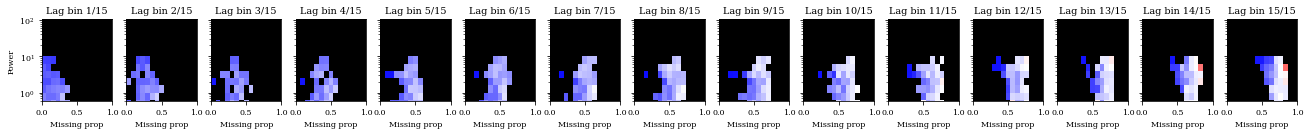

In [54]:
fig, ax = plt.subplots(1, n_bins, figsize=(1.5 * n_bins, 1.5))
# Remove spacing between subplots
plt.subplots_adjust(wspace=0.2)
for i in range(n_bins):
    c = ax[i].pcolormesh(
        heatmap_bin_edges_3d[1],
        heatmap_bin_edges_3d[2],
        heatmap_bin_vals_3d[i, :, :],
        cmap="bwr",
    )
    # plt.colorbar(label="MPE")
    c.set_clim(-100, 100)
    plt.xlabel("Missing prop")
    # ax[i].set_xlim(6e-1, 250)
    plt.title("Distribution of missing proportion and lag")
    ax[i].set_facecolor("black")
    ax[i].semilogy()
    ax[i].set_ylim(6e-1, 105)
    ax[i].set_title(
        f"Lag bin {i+1}/{n_bins}".format(np.round(heatmap_bin_edges_3d[2][i], 2))
    )
    ax[i].set_xlabel("Missing prop")
    # Remove y-axis labels for all but the first plot
    if i > 0:
        ax[i].set_yticklabels([])
ax[0].set_ylabel("Power")
# plt.savefig("psp_heatmap_3d_lag.png")

Text(0, 0.5, 'Power')

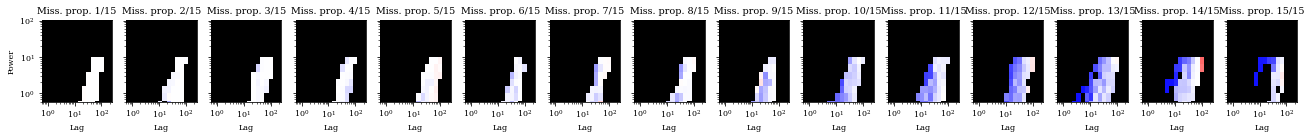

In [55]:
fig, ax = plt.subplots(1, n_bins, figsize=(1.5 * n_bins, 1.5))
# Remove spacing between subplots
plt.subplots_adjust(wspace=0.2)
for i in range(n_bins):
    c = ax[i].pcolormesh(
        heatmap_bin_edges_3d[0],
        heatmap_bin_edges_3d[2],
        heatmap_bin_vals_3d[:, i, :],
        cmap="bwr",
    )
    # plt.colorbar(label="MPE")
    c.set_clim(-100, 100)
    ax[i].set_xlim(6e-1, 250)
    ax[i].set_ylim(6e-1, 105)
    plt.title("Distribution of missing proportion and lag")
    ax[i].set_facecolor("black")
    ax[i].semilogx()
    ax[i].semilogy()
    ax[i].set_title(
        f"Miss. prop. {i+1}/{n_bins}".format(np.round(heatmap_bin_edges_3d[2][i], 2))
    )
    ax[i].set_xlabel("Lag")
    # Remove y-axis labels for all but the first plot
    if i > 0:
        ax[i].set_yticklabels([])
        ax[i].set_ylabel("")
ax[0].set_ylabel("Power")
# plt.savefig("psp_heatmap_3d_missing.png")